Setting Library

In [85]:
#Data Prrocessing
import pandas as pd
import datetime as dt
import numpy as np

#API
import vnstock
from vnstock import *

#Visualization
import matplotlib.pyplot as plt

#Predictions
import tensorflow as tf
tf.config.list_physical_devices('GPU') #GPU device
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

Load data

In [86]:
financial_health_rating('FPT')

,industryEn,loanDeposit,badLoanGrossLoan,badLoanAsset,provisionBadLoan,ticker,financialHealth,netDebtEquity,currentRatio,quickRatio,interestCoverage,netDebtEBITDA
0,Software,None,None,None,None,FPT,4.0,3,3,4,5,5


In [87]:
ticker_overview('FPT')

,exchange,shortName,industryID,industryIDv2,industry,industryEn,establishedYear,noEmployees,noShareholders,foreignPercent,website,stockRating,deltaInWeek,deltaInMonth,deltaInYear,outstandingShare,issueShare,companyType,ticker
0,HOSE,FPT Corp,310,9537,Công nghệ Thông tin,Technology,2002,37882,48598,0.49,https://www.fpt.com.vn,3.6,-0.014,0.008,0.343,1097.0,1097.0,CT,FPT


In [88]:
price_board('FPT')

,Mã CP,Giá Khớp Lệnh,KLBD/TB5D,T.độ GD,KLGD ròng(CM),%KLGD ròng (CM),RSI,MACD Volume,MACD Signal,Tín hiệu KT,Tín hiệu TB động,MA20,MA50,MA100,Phiên +/-,Đ.góp VNI,P/E,P/B,ROE,TCRating,TCBS định giá,% thay đổi giá 3D,% thay đổi giá 1M,% thay đổi giá 3M,% thay đổi giá 1Y,RS 3D,RS 1M,RS 3M,RS 1Y,RS TB,Đỉnh 1M,Đỉnh 3M,Đỉnh 1Y,Đáy 1M,Đáy 3M,Đáy 1Y,%Đỉnh 1Y,%Đáy 1Y,%Giá - %VNI (1M),%Giá - %VNI (1Y),Khối lượng Dư mua,Khối lượng Dư bán,Khớp nhiều nhất,seq,vnid3d,vnid1m,vnid3m,vnid1y,vnipe,vnipb
0,FPT,78500.0,0.95,1.46,0,0.0,34.0739,-0.39,Sell,Neutral,Strong Sell,80975.0,80284.0,77066.0,-2,-0.42,16.3,4.1,0.271712,3.6,69611,-2.5,-4.2,1.4,3.3,13.0,41.0,52.0,81.0,47.0,82800,84000,95181,78500,76000,65900,-17.5,19.1,0.8,34.3,28100,5200,79300,1677830340,-1.5,-4.9,-5.1,-31.0,11.7082,1.53963


In [89]:
df =  stock_historical_data(symbol='FPT', start_date="2021-01-01", end_date='2022-09-22') # truy xuất lịch sử giá của cổ phiếu GMD

df.head()

,Open,High,Low,Close,Volume,TradingDate
0,41435.0,41852.0,41226.0,41852.0,2151300,2021-01-04
1,41713.0,44146.0,41574.0,43590.0,2332200,2021-01-05
2,43868.0,44216.0,43312.0,43381.0,1796000,2021-01-06
3,43520.0,43729.0,43034.0,43451.0,2150200,2021-01-07
4,43799.0,44285.0,43520.0,44007.0,2720400,2021-01-08


In [90]:
stock_intraday_data(symbol='HAG', page_num=0, page_size=50000)

,price,volume,cp,rcp,a,ba,sa,hl,pcp,time
0,7450.0,379800,0.0,0.0,,0.0,0.0,True,0.0,14:45:00
1,7450.0,2000,0.0,0.0,BU,0.0,0.0,False,0.0,14:29:59
2,7450.0,300,0.0,0.0,SD,0.0,0.0,False,0.0,14:29:55
3,7450.0,500,0.0,0.0,SD,0.0,0.0,False,0.0,14:29:55
4,7450.0,1000,0.0,0.0,SD,0.0,0.0,False,0.0,14:29:55
...,...,...,...,...,...,...,...,...,...,...
3806,7640.0,200,0.0,0.0,SD,0.0,0.0,False,0.0,09:15:54
3807,7640.0,1000,0.0,0.0,SD,0.0,0.0,False,0.0,09:15:43
3808,7640.0,500,0.0,0.0,SD,0.0,0.0,False,0.0,09:15:43
3809,7640.0,100,0.0,0.0,SD,0.0,0.0,False,0.0,09:15:34


In [91]:
def crawl(company):
    start = "2020-01-01" 
    end = today = dt.datetime.now().strftime("%Y-%m-%d") 
    df = vnstock.stock_historical_data(symbol = company, start_date = start, end_date = end)
    df.to_csv(f"./data/raw/{company}.csv",encoding = "utf-8")

fhandle = open("./data/companylist.txt","r")

for line in fhandle.readlines():
    company = line.strip()
    print(f"{company}'s stock", end=' ')
    crawl(company)

FPT's stock CTG's stock LCG's stock 

In [92]:
#Company list
companies = []
fhandle = open("./data/companylist.txt","r")
order = 0
for line in fhandle.readlines():
    company = line.strip()
    order += 1
    print(f"{order}.{company}'s stock")

1.FPT's stock
2.CTG's stock
3.LCG's stock


In [93]:
company = 'LCG'
df = pd.read_csv(f"./data/raw/{company}.csv", delimiter = ",", encoding="utf-8")
df

,Unnamed: 0,Open,High,Low,Close,Volume,TradingDate
0,0,5221.0,5221.0,5145.0,5158.0,118370,2020-01-02
1,1,5158.0,5215.0,5095.0,5095.0,328340,2020-01-03
2,2,5095.0,5158.0,5038.0,5038.0,230180,2020-01-06
3,3,5038.0,5038.0,4936.0,4949.0,294740,2020-01-07
4,4,4949.0,4962.0,4715.0,4753.0,335020,2020-01-08
...,...,...,...,...,...,...,...
785,785,11600.0,12400.0,11600.0,11950.0,11401947,2023-02-27
786,786,12300.0,12300.0,11400.0,11450.0,9765011,2023-02-28
787,787,11450.0,12250.0,11250.0,12250.0,10833281,2023-03-01
788,788,12250.0,12500.0,11850.0,11850.0,9582764,2023-03-02


Preprocessing data

In [94]:
#Format data
df['TradingDate'] = pd.to_datetime(df.TradingDate, format = "%Y/%m/%d")

In [95]:
#Candlesticks
df['H-L'] = df['High'] - df['Low']

df['O-C'] = df['Open'] - df['Close']
#Labels
MA1 = 5
MA2 = 10
MA3 = 15
MA4 = 20
MA5 = 25
MA6 = 30
#Median
df[f'ME_{MA1}'] = df['Close'].rolling(window = MA1).median()
df[f'ME_{MA2}'] = df['Close'].rolling(window = MA2).median()
df[f'ME_{MA3}'] = df['Close'].rolling(window = MA3).median()
df[f'ME_{MA4}'] = df['Close'].rolling(window = MA4).median()
df[f'ME_{MA5}'] = df['Close'].rolling(window = MA5).median()
df[f'ME_{MA6}'] = df['Close'].rolling(window = MA6).median()
#Rank 
df[f'RANK_{MA1}'] = df['Close'].rolling(window = MA1).rank()
df[f'RANK_{MA2}'] = df['Close'].rolling(window = MA2).rank()
df[f'RANK_{MA3}'] = df['Close'].rolling(window = MA3).rank()
df[f'RANK_{MA4}'] = df['Close'].rolling(window = MA4).rank()
df[f'RANK_{MA5}'] = df['Close'].rolling(window = MA5).rank()
df[f'RANK_{MA6}'] = df['Close'].rolling(window = MA6).rank()
#Var
df[f'VAR_{MA1}'] = df['Close'].rolling(window = MA1).var()
df[f'VAR_{MA2}'] = df['Close'].rolling(window = MA2).var()
df[f'VAR_{MA3}'] = df['Close'].rolling(window = MA3).var()
df[f'VAR_{MA4}'] = df['Close'].rolling(window = MA4).var()
df[f'VAR_{MA5}'] = df['Close'].rolling(window = MA5).var()
df[f'VAR_{MA6}'] = df['Close'].rolling(window = MA6).var()
#Simple moving average
df[f'SMA_{MA1}'] = df['Close'].rolling(window = MA1).mean()
df[f'SMA_{MA2}'] = df['Close'].rolling(window = MA2).mean()
df[f'SMA_{MA3}'] = df['Close'].rolling(window = MA3).mean()
df[f'SMA_{MA4}'] = df['Close'].rolling(window = MA4).mean()
df[f'SMA_{MA5}'] = df['Close'].rolling(window = MA5).mean()
df[f'SMA_{MA6}'] = df['Close'].rolling(window = MA6).mean()
#Standard deviation
df[f'SD_{MA1}'] = df['Close'].rolling(window = MA1).std()
df[f'SD_{MA2}'] = df['Close'].rolling(window = MA2).std()
df[f'SD_{MA3}'] = df['Close'].rolling(window = MA3).std()
df[f'SD_{MA4}'] = df['Close'].rolling(window = MA4).std()
df[f'SD_{MA5}'] = df['Close'].rolling(window = MA5).std()
df[f'SD_{MA6}'] = df['Close'].rolling(window = MA6).std()
#Skewness
df[f'Ske_{MA1}'] = df['Close'].rolling(window = MA1).skew()
df[f'Ske_{MA2}'] = df['Close'].rolling(window = MA2).skew()
df[f'Ske_{MA3}'] = df['Close'].rolling(window = MA3).skew()
df[f'Ske_{MA4}'] = df['Close'].rolling(window = MA4).skew()
df[f'Ske_{MA5}'] = df['Close'].rolling(window = MA5).skew()
df[f'Ske_{MA6}'] = df['Close'].rolling(window = MA6).skew()
#Kurtosis
df[f'Kur_{MA1}'] = df['Close'].rolling(window = MA1).kurt()
df[f'Kur_{MA2}'] = df['Close'].rolling(window = MA2).kurt()
df[f'Kur_{MA3}'] = df['Close'].rolling(window = MA3).kurt()
df[f'Kur_{MA4}'] = df['Close'].rolling(window = MA4).kurt()
df[f'Kur_{MA5}'] = df['Close'].rolling(window = MA5).kurt()
df[f'Kur_{MA6}'] = df['Close'].rolling(window = MA6).kurt()
#Drop missing data
df.dropna(inplace = True)

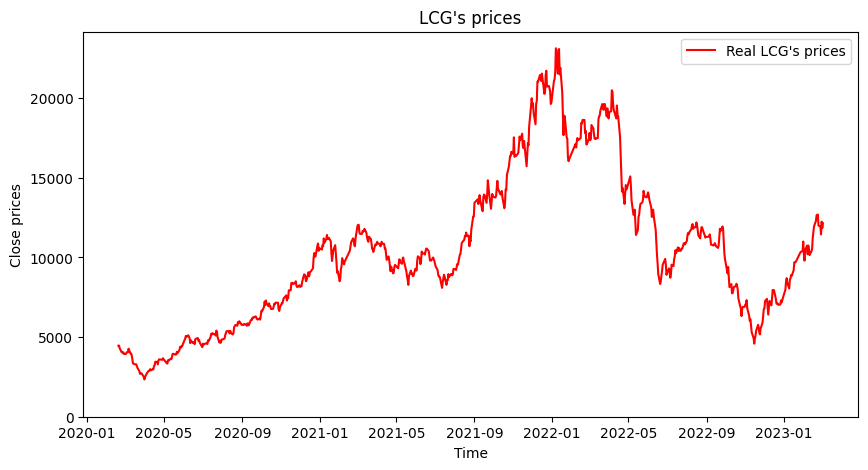

In [96]:
#Visualization
real_price = pd.DataFrame(df, columns = ['TradingDate', 'Close'])
real_price.index = real_price.TradingDate
real_price.drop('TradingDate', axis = 1, inplace = True)
plt.figure(figsize = (10,5))
plt.plot(real_price['Close'], color = "red", label = f"Real {company}'s prices")
plt.title(f"{company}'s prices")
plt.xlabel("Time")
plt.ylabel("Close prices")
plt.ylim(bottom = 0)
plt.legend() 
plt.show()

In [97]:
#Exporting data
df.to_csv(f"./data/prepaired/{company}pre.csv", encoding = "utf-8")

Processing Data

In [98]:
#Set domain
scaler_x = MinMaxScaler(feature_range = (0, 1))
scaler_y = MinMaxScaler(feature_range = (0, 1))

In [99]:
#Fit data
cols_x = ['H-L', 'O-C', 'Volume', f'ME_{MA1}', f'ME_{MA2}', f'ME_{MA3}', f'ME_{MA4}', f'ME_{MA5}', f'ME_{MA6}', f'VAR_{MA1}', f'VAR_{MA2}', f'VAR_{MA3}', f'VAR_{MA4}', f'VAR_{MA5}', f'VAR_{MA6}', f'RANK_{MA1}', f'RANK_{MA2}', f'RANK_{MA3}', f'RANK_{MA4}', f'RANK_{MA5}', f'RANK_{MA6}', f'SMA_{MA1}', f'SMA_{MA2}', f'SMA_{MA3}', f'SMA_{MA4}', f'SMA_{MA5}', f'SMA_{MA6}', f'SD_{MA1}' ,f'SD_{MA2}', f'SD_{MA3}', f'SD_{MA4}', f'SD_{MA5}', f'SD_{MA6}', f'Ske_{MA1}', f'Ske_{MA2}', f'Ske_{MA3}', f'Ske_{MA4}', f'Ske_{MA5}', f'Ske_{MA6}', f'Kur_{MA1}', f'Kur_{MA2}', f'Kur_{MA3}', f'Kur_{MA4}', f'Kur_{MA5}', f'Kur_{MA6}']
cols_y = ['Close']
scaled_data_x = scaler_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x))) 
scaled_data_y = scaler_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

In [100]:
df.head()

,Unnamed: 0,Open,High,Low,Close,Volume,TradingDate,H-L,O-C,ME_5,ME_10,ME_15,ME_20,ME_25,ME_30,RANK_5,RANK_10,RANK_15,RANK_20,RANK_25,RANK_30,VAR_5,VAR_10,VAR_15,VAR_20,VAR_25,VAR_30,SMA_5,SMA_10,SMA_15,SMA_20,SMA_25,SMA_30,SD_5,SD_10,SD_15,SD_20,SD_25,SD_30,Ske_5,Ske_10,Ske_15,Ske_20,Ske_25,Ske_30,Kur_5,Kur_10,Kur_15,Kur_20,Kur_25,Kur_30
29,29,4588.0,4588.0,4455.0,4462.0,96910,2020-02-19,133.0,126.0,4335.0,4288.0,4272.0,4319.5,4462.0,4563.0,4.0,9.0,13.0,13.0,13.0,13.0,14377.8,11037.122222,23408.685714,50854.831579,58287.423333,96395.426437,4360.6,4309.3,4277.400000,4378.90,4440.56,4533.566667,119.907464,105.057709,152.998973,225.510158,241.427884,310.476129,0.259270,0.903156,0.285154,0.288607,-0.039857,0.257072,-2.413536,0.048002,-0.133838,-1.046293,-1.260882,-0.762327
30,30,4462.0,4525.0,4462.0,4468.0,138630,2020-02-20,63.0,-6.0,4462.0,4288.0,4272.0,4319.5,4462.0,4531.5,4.0,9.0,14.0,14.0,14.0,14.0,9985.8,13565.600000,19881.380952,48483.418421,51611.693333,82551.012644,4408.6,4322.6,4270.666667,4371.95,4425.88,4510.566667,99.928975,116.471456,141.001351,220.189506,227.182071,287.316920,-0.693859,0.582381,0.004347,0.354151,-0.073779,0.202556,-1.881361,-1.255349,-0.392576,-0.830691,-1.208703,-0.745361
31,31,4462.0,4468.0,4272.0,4304.0,215870,2020-02-21,196.0,158.0,4462.0,4288.0,4272.0,4304.0,4335.0,4487.0,1.0,6.0,9.5,10.5,10.5,10.5,8005.0,13565.600000,19944.352381,45389.944737,47261.893333,71525.200000,4415.0,4322.6,4271.933333,4356.45,4407.68,4484.200000,89.470666,116.471456,141.224475,213.049160,217.398007,267.441956,-0.508089,0.582381,-0.025724,0.546270,0.018536,0.166532,-2.652933,-1.255349,-0.413048,-0.415785,-1.120429,-0.833374
32,32,4240.0,4240.0,4044.0,4057.0,362710,2020-02-24,196.0,183.0,4462.0,4288.0,4272.0,4294.5,4335.0,4465.0,1.0,1.0,1.0,2.0,2.0,2.0,34581.8,20273.566667,18667.552381,43199.431579,48397.073333,66136.465517,4359.4,4304.3,4274.466667,4324.80,4382.36,4451.500000,185.961824,142.385275,136.629252,207.844729,219.993348,257.170110,-1.445606,-0.070685,0.109439,0.683478,0.115758,0.059979,1.494457,-0.593116,-0.569913,0.063650,-1.065744,-1.082560
33,33,4050.0,4114.0,4050.0,4082.0,184250,2020-02-25,64.0,-32.0,4304.0,4288.0,4272.0,4278.5,4304.0,4398.5,2.0,2.0,2.0,4.0,4.0,4.0,39457.8,23863.511111,18297.238095,35467.039474,49833.473333,61445.696552,4274.6,4294.8,4275.333333,4291.25,4361.84,4422.600000,198.639875,154.478190,135.267284,188.326948,223.234122,247.882425,-0.191763,-0.160578,0.142030,0.706490,0.261952,0.022429,-2.981173,-0.906836,-0.578919,0.433841,-1.019261,-1.292549


In [101]:
#Training seq X and output value Y
pre_day = 7
x_total = [] # Variables today
y_total = [] #Close price tomorrow
for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i - pre_day : i])
    y_total.append(scaled_data_y[i])

In [102]:
#Set test
test_size = 60

#Traning set
x_train = np.array(x_total[:len(x_total)-test_size]) #tranning set (0, 30)
y_train = np.array(y_total[:len(y_total)-test_size]) #taget tranning set

#Predicted set
x_test = np.array(x_total[len(x_total)-test_size:]) #predicted set (31,...)
y_test = np.array(y_total[len(y_total)-test_size:]) #taget predicted set

#Structure of tranning data
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(694, 7, 45) (694, 1) (60, 7, 45) (60, 1)


Build Model

In [103]:
#Layers
def CreateModel(cells):
    model = Sequential()
    model.add(LSTM(units = cells, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', input_shape = (7, 45)))
    model.add(Dropout(0.1))
    model.add(LSTM(units = cells, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dropout(0.1))
    model.add(LSTM(units = cells))
    model.add(Dropout(0.1))
    model.add(Dense(units = len(cols_y)))                     
    return model
model = CreateModel(270)

Epoch 1/2
555/555 [==============================] - 18s 25ms/step - loss: 4.1391e-04 - accuracy: 0.0036 - val_loss: 4.1016e-04 - val_accuracy: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 1s 26ms/step


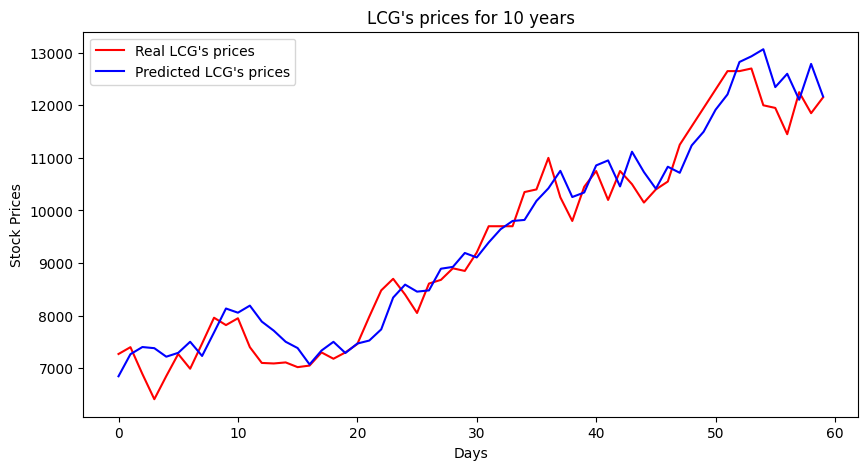

In [104]:
from keras.models import load_model
model = load_model(f"./models/{company}.h5")

model.compile(optimizer = Adam(learning_rate = 0.00001), loss = 'mean_squared_error', metrics = ['accuracy']) #Optimizer, loss
history = model.fit(x_train, y_train, epochs= 2, batch_size= 1, use_multiprocessing= True, validation_split= 0.2, shuffle= True)

from keras.models import save_model
save_model(model, f"./models/{company}.h5", include_optimizer = True)

#Config real price
real_price = df[len(df)-test_size:]['Close'].values.reshape(-1, 1)
real_price = np.array(real_price)
real_price = real_price.reshape(real_price.shape[0], 1)

#Config predicted price
predict_prices = model.predict(x_test)
predict_prices = scaler_y.inverse_transform(predict_prices)

# Predicted days
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(real_price, color="red", label=f"Real {company}'s prices")
ax.plot(predict_prices, color="blue", label=f"Predicted {company}'s prices")
ax.set_title(f"{company}'s prices for 10 years")
ax.set_xlabel("Days")
ax.set_ylabel("Stock Prices")
ax.legend()
plt.show()

22/22 [==============================] - 1s 25ms/step


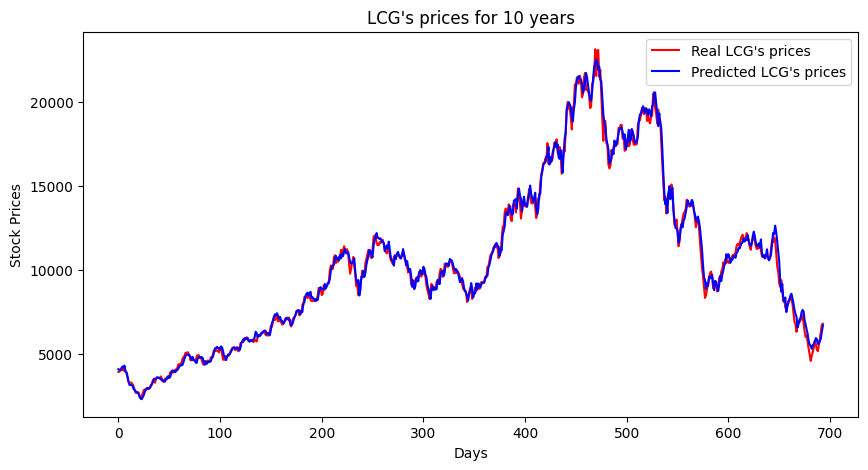

In [105]:
#Config real price
real_price = df[7:len(df)-test_size]['Close'].values.reshape(-1, 1)
real_price = np.array(real_price)
real_price = real_price.reshape(real_price.shape[0], 1)

#Config predicted price
predict_prices = model.predict(x_train)
predict_prices = scaler_y.inverse_transform(predict_prices)

#Predicted days
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(real_price, color="red", label=f"Real {company}'s prices")
ax.plot(predict_prices, color="blue", label=f"Predicted {company}'s prices")
ax.set_title(f"{company}'s prices for 10 years")
ax.set_xlabel("Days")
ax.set_ylabel("Stock Prices")
ax.legend()
plt.show()